## **FORWARD GRADIENT**
Given a function $f:\mathbb{R}^n\to\mathbb{R}$, the forward gradient $\mathbf{g}:\mathbb{R}^n\to\mathbb{R}^n$ is defined as:
$$\mathbf{g}_\mathbf{v}(x):= \nabla_\mathbf{v} f(x)\cdot\mathbf{v}=(\nabla f(x)\cdot\mathbf{v})\mathbf{v}$$
where $x\in\mathbb{R}^n$ is the point at which we are evaluating
the gradient, $\mathbf{v}\in\mathbb{R}^n$ is a perturbation vector taken as a multivariate random variable $\mathbf{v}\backsim p(\mathbf{v})$ such that $\mathbf{v}$’s scalar components $v_i$ are independent and have zero mean and unit variance for all $i$, and $\nabla f(x)\cdot\mathbf{v}\in\mathbb{R}$ is the directional
derivative of $f$ at point $x$ in direction $\mathbf{v}$.

Moreover, the *forward gradient* $\mathbf{g}_\mathbf{v}(x)$ is an unbiased estimator of the gradient $\nabla f(x)$.

In forward AD, one would need to evaluate $f$ forward $n$ times (one for each input $x_i with i=1,\dots,n$) in order to compute each partial derivative $\partial f/\partial x_i$. To have runtime advantages over backpropagation, we need to work with just a single run of the algorithm, not $n$ runs. In a single forward run, the direction $\mathbf{v}$ can be interpreted as a weight vector in a weighted sum of sensitivities $\sum_i \frac{\partial f}{\partial x_i}v_i$: we therefore use $\mathbf{v}$ to attribute the overall sensitivity back to each individual parameter $x_i$ [3].

Before proceeding, let's import some useful tools:

In [168]:
# Utils
import matplotlib.pyplot as plt
import numpy as np
import functools
import time

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.autograd.forward_ad as fwAD
import functorch

# For datasets
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

##### **Example [1.1]**
Let's try to perform **forward gradient descent** using the *forward gradients* on several functions. First, let's define a function that will plot the FGD:

In [129]:
def plot_fgd(f_name, f, primals, min, l_rate, epochs, t1=torch.linspace(-20, 5, 100), t2=torch.linspace(-5, 20, 100)):
    # Define v as canonic base
    v_canonic = [tuple([torch.ones(p.shape) if i==j else torch.zeros(p.shape) for i, p in enumerate(primals)]) for j in range(len(primals))]

    # Initialize list of x values, y values, fwd grads and true grads:
    x_values = list()
    y_values = list()
    fwd_grads = list()
    true_grads = list()

    # Perform FDG (forward gradient descent)
    for i in range(epochs):
        # Sample perturbation
        v_params = tuple([torch.rand_like(p) for p in primals])
        # Compute f and df
        val, jvp = functorch.jvp(f, primals, v_params)
        y_values.append(val)
        # Parameters update using forward gradient
        x_values.append([p.sub_(l_rate * jvp * v_params[j]).item() for j, p in enumerate(primals)])
        # Save true gradients and fwd gradients
        fwd_grads.append([jvp * v_params[j] for j, p in enumerate(primals)])
        true_grads.append([functorch.jvp(f, primals, v)[1].item() for v in v_canonic])

    # Transform to tensor
    x_values = torch.tensor(x_values)
    fwd_grads = torch.tensor(fwd_grads)
    true_grads = torch.tensor(true_grads)

    # Define the parameters for the plot
    T1, T2 = torch.meshgrid(t1, t2)

    # Set up a figure
    fig = plt.figure(figsize=plt.figaspect(.25))
    fig.suptitle(f_name, fontsize=15, fontweight='bold', y=1.05)

    # First subplot (FGD)
    ax1 = fig.add_subplot(1, 3, 2, projection='3d')
    ax1 = plt.axes(projection='3d')
    ax1.grid(False)
    ax1.set_title(r"FGD on $f(\mathbf{x})$ using forward gradient $\mathbf{g}_\mathbf{v}$")
    # Plot f, GD steps and minima
    ax1.plot_surface(T1, T2, f(T1, T2), cmap='bone', alpha=0.6)
    ax1.plot(x_values[:, 0], x_values[:, 1], f(*x_values.T), '-', color='black', label="FGD steps", alpha=1)
    ax1.scatter(min[0], min[1], min[2], color='r', label='Minima')
    # Add labels and legend
    ax1.set_xlabel(r'$x_1$')
    ax1.set_ylabel(r'$x_2$')
    ax1.set_zlabel(r'$f(\mathbf{x})$')
    ax1.legend(loc=(0, 0.7))
    
    # Second subplot (Y through epochs)
    ax2 = fig.add_subplot(1, 3, 1)
    ax2.plot(y_values)
    ax2.set_title(r'$f(\mathbf{x})$ value through the epochs')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel(r'$f(x_1, x_2)$')
    
    # Third subplot (grad error)
    ax3 = fig.add_subplot(1, 3, 3, alpha=0.5)
    ax3.plot(true_grads[:,0]-fwd_grads[:,0], label=r'$x_1$ error')
    ax3.plot(true_grads[:,1]-fwd_grads[:,1], label=r'$x_2$ error')
    ax3.set_title(r"Error between $\nabla f$ and $\mathbf{g}_\mathbf{v}$")
    ax3.set_xlabel(r'SDG iterations')
    ax3.set_ylabel('error')
    ax3.legend()
    
    plt.show()

Let's perform FDG on the [sum squares function](https://www.sfu.ca/~ssurjano/sumsqu.html):

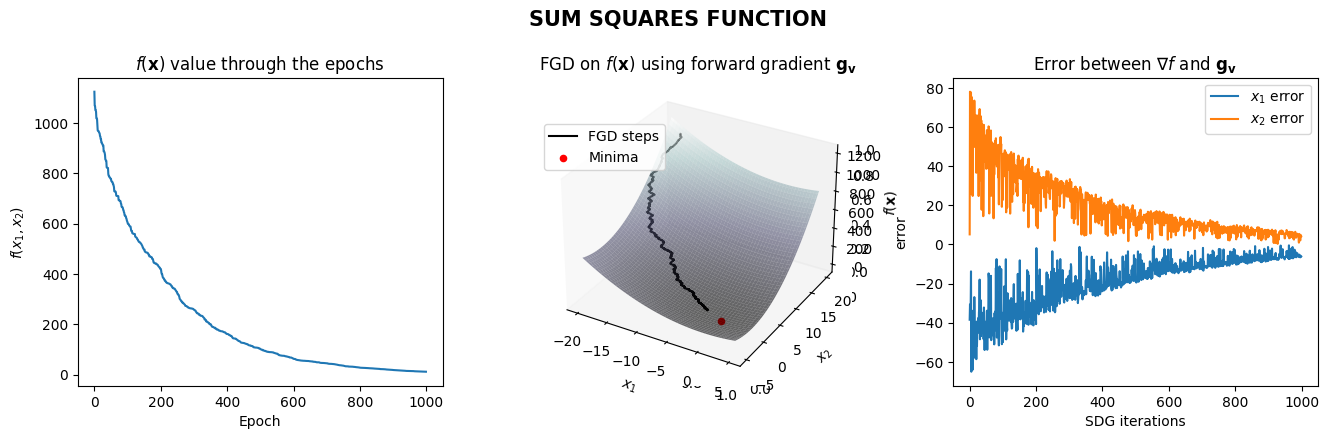

In [130]:
# Define the function
def sumsquares(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2 
    
# Define primals (x1, x2) 
primals = (torch.tensor([-18.]), torch.tensor([20.]))

plot_fgd("SUM SQUARES FUNCTION", sumsquares, primals, min=[0,0,0], l_rate=1e-2, epochs=1000)

Let's now try it on the [trid function](https://www.sfu.ca/~ssurjano/trid.html):

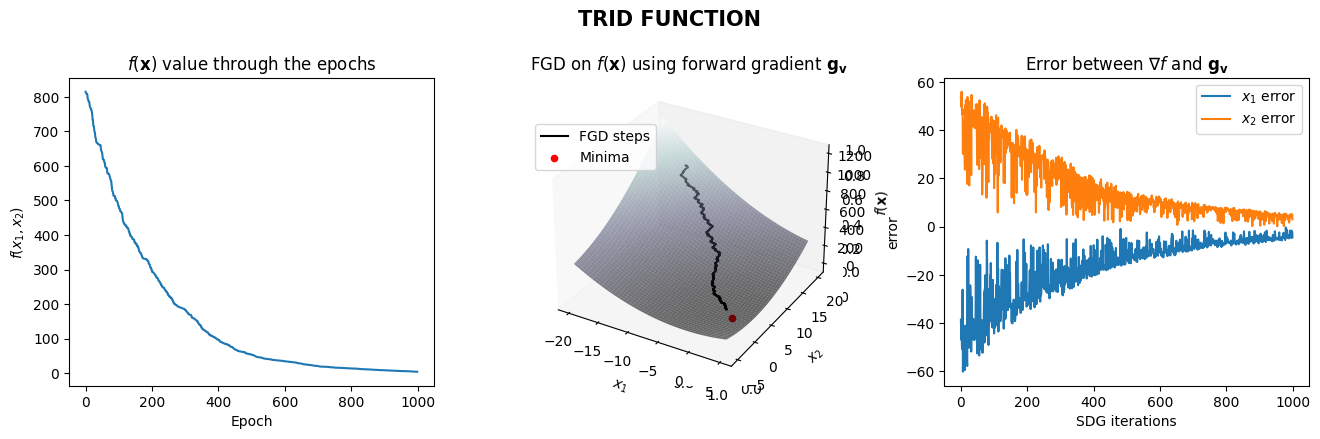

In [131]:
# Define the function
def trid(x1, x2):
    return (x1 - 1) ** 2 + (x2 - 1) ** 2 - x2 * x1

# Define primals (x1, x2) 
primals = (torch.tensor([-15.]), torch.tensor([18.]))

plot_fgd("TRID FUNCTION", trid, primals, min=[2,2,-12], l_rate=0.01, epochs=1000)

For the [rosenbrock function](https://www.sfu.ca/~ssurjano/rosen.html) we get the following result:

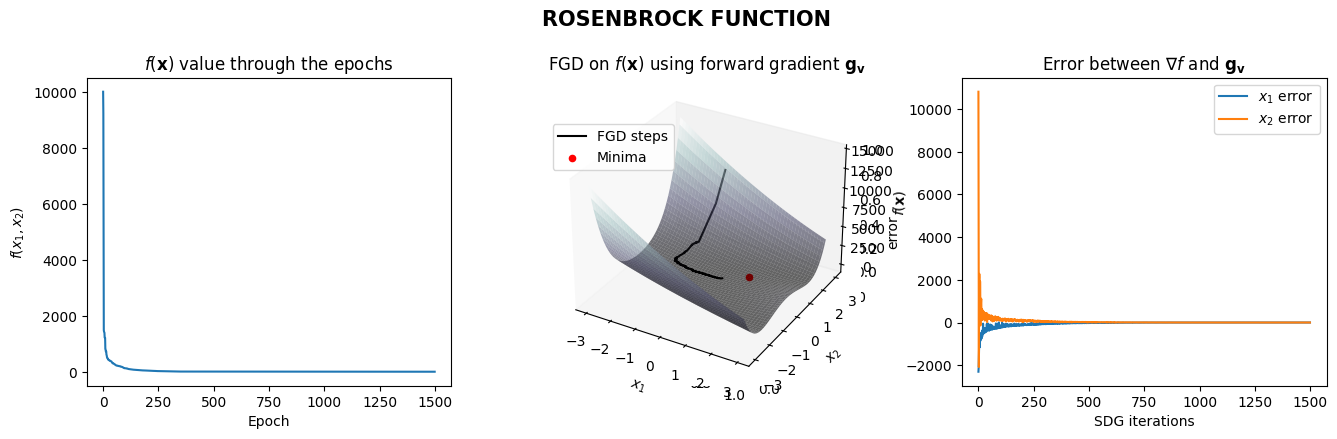

In [132]:
def rosenbrock(x1, x2):
    return 100 * (x1 - x2 ** 2) ** 2 + (x2 - 1) ** 2

# Define primals (x1, x2) 
primals = (torch.tensor([-1.]), torch.tensor([3.]))

plot_fgd("ROSENBROCK FUNCTION", rosenbrock, primals, min=[1,1,0], l_rate=2e-4, epochs=1500, t1=torch.linspace(-3, 3, 100), t2=torch.linspace(-3, 3, 100))

And now the [beale function](https://www.sfu.ca/~ssurjano/beale.html):

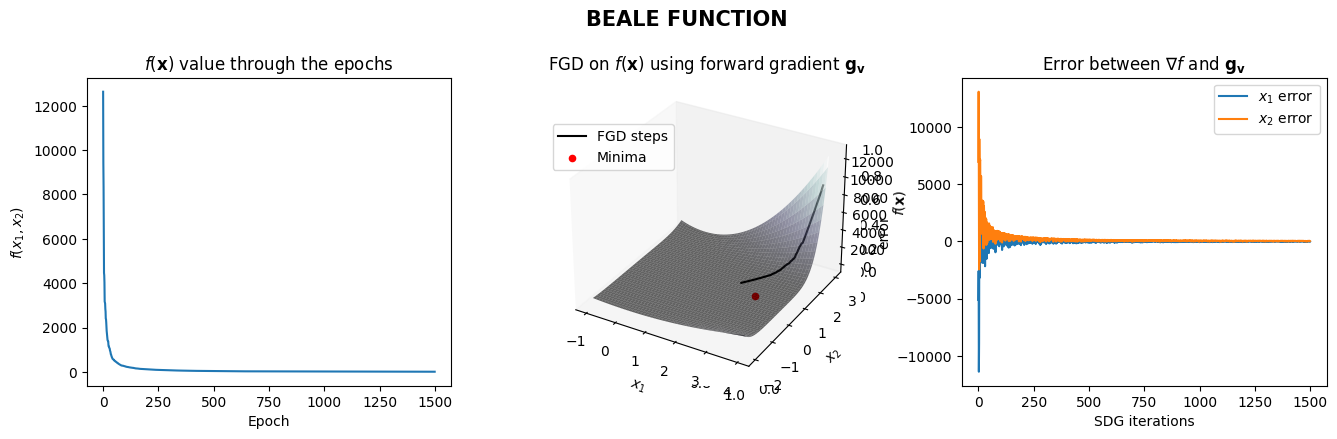

In [133]:
def beale(x1, x2):
    return (1.5 - x1 + x1*x2)**2 + (2.25 - x1 + x1*x2**2)**2 + (2.625 - x1 + x1*x2**3)**2

# Define primals (x1, x2) 
primals = (torch.tensor([4.]), torch.tensor([3.]))

plot_fgd("BEALE FUNCTION", beale, primals, min=[3,.5,0], l_rate=1e-5, epochs=1500, t1=torch.linspace(-1, 4, 100), t2=torch.linspace(-2, 3, 100))

---

Let's now try to apply the forward gradient to a FNN.

First, let's define a cross entropy 

In [141]:
def utils_cross_entropy(params, func, x, t):
    # Compute the prediction
    y_pred = func(params, x)
    # Compute the CE loss
    loss = F.cross_entropy(y_pred, t, reduction='mean')
    return loss

Now let's define a simple FNN: for consistency we will use the same layout as the one proposed in the paper.

In [142]:
# Paper FNN
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Paper CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=3136, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 3136)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Our model will be trained using the MNIST dataset and the same batch size as the one used in the paper:

In [185]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the batch size
batch_size = 64

# Create train and test dataset...
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)

# ... and respective dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Finally, let's train the network on the dataset. 

Before proceeding, it is important to comment on some sections of the code:
1. To extract the parameters of the model, we will use the *torch.make_functional* function, that given a *torch.nn.Module* extracts the state (params) and returns a functional version of the model.
2. For the perturbation vector, we will use the *torch.rand_like* function, that returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1 (exactly what we need).
3. The *utils_cross_entropy* will be used by the *functorch.jvp* function, that will input only primals and tangents to it. Since our cross entropy also requires "params" and "func" to be specified, we will need to use *functool.partial*: this function will create a new callable function that behave like cross entropy but has 2 positional arguments less (params and funct indeed). The missing arguments will be always substituted by the one specified when calling *functool.partial*.

To be congruent with the paper, when training we will use a learning rate decay with $\eta_i = \eta_0 e^{-ik}$ where $\eta_i$ is the learning rate at iteration $i$, $\eta_0$ is the initial learning rate, and $k=10^{-4}$.

Let's now define two useful functions to train our models:

In [181]:
# Given a model, train it using FGD
def train_fgd(model, train_loader, num_epochs=20, learning_rate=2e-4, input_size=28*28):
    print(f'\n\nTraining {model.__class__.__name__} with FGD for {num_epochs} epochs...')

    # Initialize losses and times
    losses = list()
    times = list([0])

    with torch.no_grad():
        # Get the functional version of the model with functorch
        func, params = functorch.make_functional(model)
        
        # Train the network with FGD (forward Gradient Descent)
        for epoch in range(num_epochs): 
            for i, (images, labels) in enumerate(train_loader): 
                # Start time
                t0 = time.time()
                # Reshape the images (for FNN only)
                if isinstance(model, FNN): images = images.reshape(-1, input_size)
                # Create callable CE function
                f = functools.partial(utils_cross_entropy, func=func, x=images, t=labels)            
                # Sample perturbation (for each parameter of the model)
                v_params = tuple([torch.randn_like(p) for p in params])  
                # Forward AD
                loss, jvp = functorch.jvp(f, (tuple(params),), (v_params,))
                # Decay learning rate
                l_rate = learning_rate * np.exp(-((i+epoch*len(train_loader))*1e-4))
                # For each parameter
                for j, p in enumerate(params):
                    # Compute forward gradient
                    g = jvp * v_params[j]
                    # Parameters update
                    p.sub_(l_rate * g)  
                # End time
                t1 = time.time()     
                # Update losses and times
                losses.append(loss)
                times.append(times[-1]+t1-t0)     
                # Print the statistics
                if (i+1) % batch_size == 0:
                    print (f'Epoch [{epoch+1}/{num_epochs}],\tStep [{i+1}/{len(train_loader)}],\t' +
                            f'Iteraion [{i+1+epoch*len(train_loader)}/{len(train_loader)*num_epochs}],\t' +
                            f'Loss: {loss:.4f},\tTime: {t1-t0:.2f}')
    print('Finished FGD Training')
    return losses, times

# Given a model, train it using SGD
def train_sgd(model, train_loader, num_epochs=20, learning_rate=2e-4, input_size=28*28):
    print(f'\n\nTraining {model.__class__.__name__} with SGD for {num_epochs} epochs...')

    # Define criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Initialize losses and times
    losses = list()
    times = list([0])

    # Train the model
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Start time
            t0 = time.time()
            # Reshape the images (for FNN only)
            if isinstance(model, FNN): images = images.reshape(-1, input_size)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # End time
            t1 = time.time()
            # Update losses and times
            losses.append(loss.item())
            times.append(times[-1]+t1-t0)  
            # Print the statistics
            if (i+1) % batch_size == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}],\tStep [{i+1}/{len(train_loader)}],\t' +
                        f'Iteraion [{i+1+epoch*len(train_loader)}/{len(train_loader)*num_epochs}],\t' +
                        f'Loss: {loss:.4f},\tTime: {t1-t0:.2f}')
    print('Finished SGD Training')
    return losses, times

Let's now compare FNN on FGD and SGD:

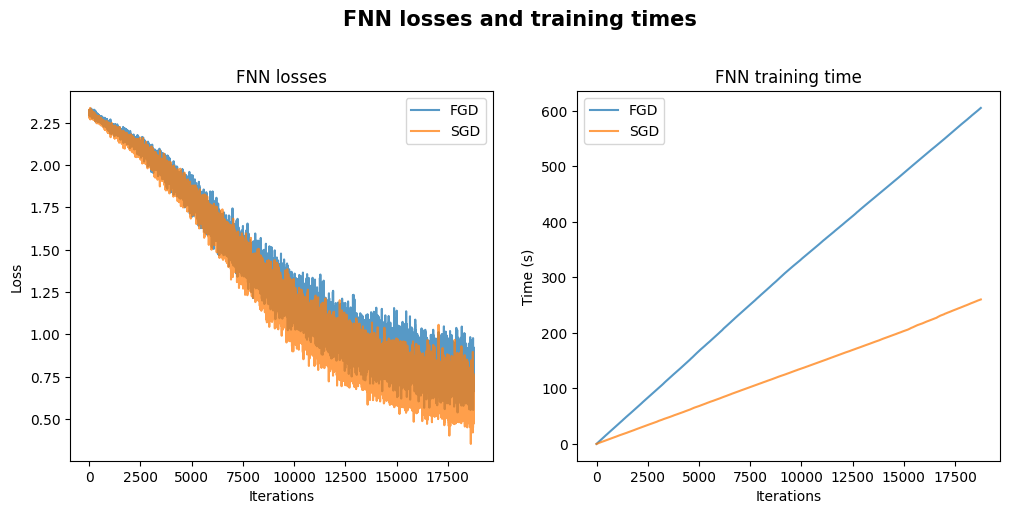

In [186]:
# Train FNN with FGD
fnn_fgd_l, fnn_fgd_t = train_fgd(FNN(), train_loader=train_loader, num_epochs=20)
# Train FNN with SGD
fnn_sgd_l, fnn_sgd_t = train_sgd(FNN(), train_loader=train_loader, num_epochs=20)

# Set up a figure
fig = plt.figure(figsize=plt.figaspect(.4))
fig.suptitle("FNN losses and training times", fontsize=15, fontweight='bold', y=1.05)

# First subplot (Losses)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("FNN losses")
ax1.plot(fnn_fgd_l, label='FGD', alpha=0.75)
ax1.plot(fnn_sgd_l, label='SGD', alpha=0.75)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.legend()

# Second subplot (Times)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("FNN training time")
ax2.plot(fnn_fgd_t, label='FGD', alpha=0.75)
ax2.plot(fnn_sgd_t, label='SGD', alpha=0.75)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Time (s)")
ax2.legend()

plt.show()

With CNN training on FGD and SGD we get the following results instead:

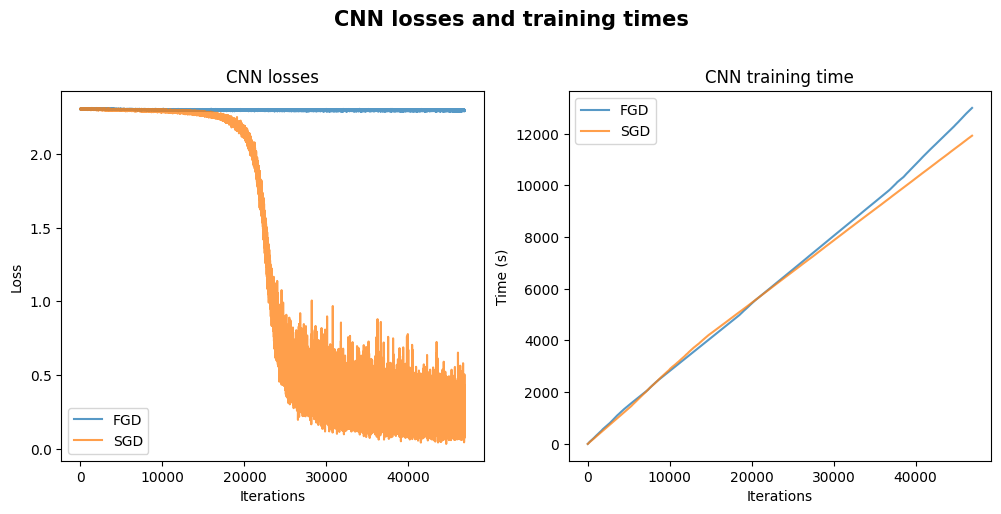

In [187]:
# Train CNN with FGD
cnn_fgd_l, cnn_fgd_t = train_fgd(CNN(), train_loader=train_loader, num_epochs=50)
# Train CNN with SGD
cnn_sgd_l, cnn_sgd_t = train_sgd(CNN(), train_loader=train_loader, num_epochs=50)

# Set up a figure
fig = plt.figure(figsize=plt.figaspect(.4))
fig.suptitle("CNN losses and training times", fontsize=15, fontweight='bold', y=1.05)

# First subplot (Losses)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("CNN losses")
ax1.plot(cnn_fgd_l, label='FGD', alpha=0.75)
ax1.plot(cnn_sgd_l, label='SGD', alpha=0.75)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.legend()

# Second subplot (Times)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("CNN training time")
ax2.plot(cnn_fgd_t, label='FGD', alpha=0.75)
ax2.plot(cnn_sgd_t, label='SGD', alpha=0.75)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Time (s)")
ax2.legend()

plt.show()

### References

[1] [Derivative](https://en.wikipedia.org/wiki/Derivative).

[2] Kofi Asiedu Brempong, 2020 [I Finally Understood Backpropagation: And you can too...](https://towardsdatascience.com/i-finally-understood-backpropagation-and-you-can-too-44f7dd98ff52).

[3] Atılım Gunes Baydin, Barak A. Pearlmutter, Don Syme, Frank Wood, Philip Torr, 2022. [Gradients without Backpropagation](https://arxiv.org/abs/2005.00817).

[4] [Dual number](https://en.wikipedia.org/wiki/Dual_number).

[5] Mark Saroufim, 2019. [Automatic Differentiation Step by Step](https://marksaroufim.medium.com/automatic-differentiation-step-by-step-24240f97a6e6).

[6] Robert Lange, 2019. [Forward Mode Automatic Differentiation & Dual Numbers](https://towardsdatascience.com/forward-mode-automatic-differentiation-dual-numbers-8f47351064bf).

[7] Atılım Gunes Baydin, Barak A. Pearlmutter, Alexey Andreyevich Radul, Jeffrey Mark Siskind, 2018. [Automatic Differentiation in Machine Learning: a Survey](https://www.jmlr.org/papers/volume18/17-468/17-468.pdf).

[8] Daniel Worrall, 2021. [Dual numbers](https://danielewworrall.github.io/blog/2021/08/dual-numbers/)

[9] Dr. Robert Kübler, 2022. [Papers Simplified: Gradients without Backpropagation](https://towardsdatascience.com/papers-simplified-gradients-without-backpropagation-96e8533943fc).